In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast  # For literal_eval to convert string representation of list to actual list
from gensim.models import KeyedVectors
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gensim
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline
import plotly
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
import nltk
from nltk.corpus import stopwords

import re
import string

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/afinn-lexicon/Afinn.csv
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2/saved_model.pb
/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2/variables/variables.index
/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2/variables/variables.data-00000-of-00001


In [11]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Gensim version:", gensim.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Plotly version:", plotly.__version__)
print("NLTK version:", nltk.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.1
Gensim version: 4.3.2
Matplotlib version: 3.7.5
Seaborn version: 0.12.2
Plotly version: 5.18.0
NLTK version: 3.2.4


In [218]:
df_train=pd.read_csv("/data/train.csv")
df_test=pd.read_csv("/data/test.csv")

In [219]:
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


<h1>Exploratory Data Analysis</h1>

In [220]:
print(df_train.shape)
print(df_test.shape)

(27481, 4)
(3534, 3)


In [221]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [222]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [258]:
sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}

df_train['numerical_sentiment'] = df_train['sentiment'].map(sentiment_mapping)

In [259]:
Y_actual=df_train.numerical_sentiment

In [260]:
df_train.describe()

,numerical_sentiment
count,27480.000000
mean,0.029148
std,0.771118
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


In [226]:
temp = df_train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<Axes: xlabel='sentiment', ylabel='count'>

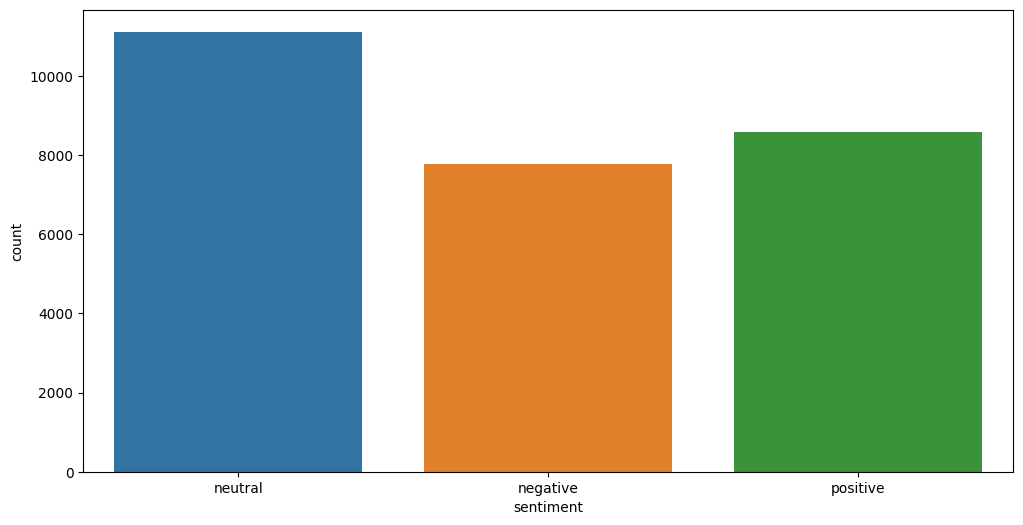

In [227]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df_train)

In [228]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [229]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [230]:
df_train['text'] = df_train['text'].apply(lambda x:clean_text(x))
df_train['selected_text'] = df_train['selected_text'].apply(lambda x:clean_text(x))

In [231]:
df_train['temp_list'] = df_train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df_train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [232]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
df_train['temp_list'] = df_train['temp_list'].apply(lambda x:remove_stopword(x))

In [233]:
top = Counter([item for sublist in df_train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [234]:
df_train['temp_list1'] = df_train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
df_train['temp_list1'] = df_train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [235]:
top = Counter([item for sublist in df_train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [261]:
df_train.head()

,textID,text,selected_text,sentiment,numerical_sentiment,temp_list,temp_list1
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,0,"[id, responded, going]","[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,-1,"[sooo, sad]","[sooo, sad, miss, san, diego]"
2,088c60f138,my boss is bullying me,bullying me,negative,-1,[bullying],"[boss, bullying]"
3,9642c003ef,what interview leave me alone,leave me alone,negative,-1,"[leave, alone]","[interview, leave, alone]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,-1,[sons],"[sons, couldnt, put, releases, already, bought]"


In [237]:
# Load pre-trained Word2Vec model
def load_word2vec_model(model_path):
    return KeyedVectors.load_word2vec_format(model_path, binary=True)

In [5]:
afinn = pd.read_csv("/data/Afinn.csv",encoding='ISO-8859-1')


afinn.sample(5)

,word,value
83,aggressions,-2
768,doubtful,-1
1388,joyfully,3
222,backs,1
727,disqualified,-2


In [257]:
df_train.head()

,textID,text,selected_text,sentiment,numerical_sentiment,temp_list,temp_list1
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,NaN,"[id, responded, going]","[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,NaN,"[sooo, sad]","[sooo, sad, miss, san, diego]"
2,088c60f138,my boss is bullying me,bullying me,negative,NaN,[bullying],"[boss, bullying]"
3,9642c003ef,what interview leave me alone,leave me alone,negative,NaN,"[leave, alone]","[interview, leave, alone]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,NaN,[sons],"[sons, couldnt, put, releases, already, bought]"


In [269]:
import tensorflow as tf
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
# Load the Universal Sentence Encoder model from Kaggle file path
def load_use_model():
    return tf.saved_model.load("Enter Google-Sentence-Encoder path here")#Read data/information.txt

def calculate_sentiment_with_use(text, afinn, use_model):
    text_embedding = use_model([text]).numpy()[0]
    
    sentiment_score = 0.0
    count = 0
    
    for index,row in afinn.iterrows():
        word=row['word']
        value=row['value']
        try:
            word_embedding = use_model([word]).numpy()[0]
            similarity_matrix = cosine_similarity([text_embedding], [word_embedding])
            
            if similarity_matrix.size == 0:
                continue
            
            similarity = similarity_matrix[0][0]
            if not np.isnan(similarity) and not np.isinf(similarity):
                sentiment_score += float(value) * similarity
                count += 1
        except KeyError:
            continue
            
    if count > 0:
        sentiment_score /= count
    
    print(f"Text: {text}")
    print(f"Sentiment Score: {sentiment_score}")
    
    return sentiment_score


def senti_score():
    afinn = pd.read_csv("/kaggle/input/afinn-lexicon/Afinn.csv",encoding='ISO-8859-1')
    use_model = load_use_model() 
    
    i = 0
    tot = 0
    
    for index, row in df_train.iterrows():
        text = row['text']
        score = calculate_sentiment_with_use(text, afinn, use_model)
       

        if score > 0:
            sentiment = "positive"
        elif score < 0:
            sentiment = "negative"
        else:
            sentiment = "neutral"
       
        if sentiment == row['sentiment'] or row['sentiment'] == 'neutral':
            i += 1

        tot=tot+1
        
        print(f"ID: {row['textID']}")
        print(f"Text: {text}")
        print(f"Sentiment Score: {score}")
        print(f"Sentiment: {sentiment}")
        print(f"Actual Sentiment: {row['sentiment']}")
        print(f"ratio: {i/tot}\n")


In [270]:
senti_score()

Text:  id have responded if i were going
Sentiment Score: -0.07462394971014735
ID: cb774db0d1
Text:  id have responded if i were going
Sentiment Score: -0.07462394971014735
Sentiment: negative
Actual Sentiment: neutral
ratio: 1.0

Text:  sooo sad i will miss you here in san diego
Sentiment Score: -0.03324481030690364
ID: 549e992a42
Text:  sooo sad i will miss you here in san diego
Sentiment Score: -0.03324481030690364
Sentiment: negative
Actual Sentiment: negative
ratio: 1.0

Text: my boss is bullying me
Sentiment Score: -0.09070192533423
ID: 088c60f138
Text: my boss is bullying me
Sentiment Score: -0.09070192533423
Sentiment: negative
Actual Sentiment: negative
ratio: 1.0

Text:  what interview leave me alone
Sentiment Score: -0.049378481648259274
ID: 9642c003ef
Text:  what interview leave me alone
Sentiment Score: -0.049378481648259274
Sentiment: negative
Actual Sentiment: negative
ratio: 1.0

Text:  sons of  why couldnt they put them on the releases we already bought
Sentiment Score

KeyboardInterrupt: 